<a href="https://colab.research.google.com/github/karenbennis/Xy/blob/Blake/Copy_of_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><br>**ETL**<br><br>

In [1]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

#Interact with SQL
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

# Start Spark Session(Creating spark application with name defined by appName()) ---IMPORTED WITH EVERY COLAB NOTEBOOK
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("database_transformation").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()


--2020-07-13 00:49:53--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.78MB/s    in 0.2s    

2020-07-13 00:49:54 (4.78 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [2]:
# gcloud login and check the DB
!gcloud auth login
!gcloud config set project 'xy-yelp'
!gcloud sql instances describe 'xy-yelp'

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&code_challenge=rN-BcIVuiLVZVmUgxOpI4MHwitsJxszylwx48bQYaiE&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: 4/1wFSObVo1DTCVfCuqsd60DbEgC70ivP1f9nHst4cFbSuBApZL0YWbHw

You are now logged in as [belnap.b.01@gmail.com].
Your current project is [xy-yelp].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].
backendType: SECOND_GEN
connectionName: xy-yelp:northamerica-northeast1:xy-yelp
databas

In [3]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy
# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="xy-yelp:northamerica-northeast1:xy-yelp"=tcp:5432 &
!sleep 30s

cloud_sql_proxy: Text file busy
nohup: appending output to 'nohup.out'


In [4]:
db_password = 'kjhbyelpdb'

In [5]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://127.0.0.1:5432/xy_yelp_db"
config = {"user":"postgres", 
          "password": db_password, 
          "driver":"org.postgresql.Driver"}

In [6]:
# Read data from database
review_df2 = spark.read \
    .jdbc(url=jdbc_url, table='review',
          properties=config)
review_df2.show(5)

+--------------------+--------------------+-----+----+------+-----+-----------+-----------+
|           review_id|         review_text|stars|cool|useful|funny|review_date|review_type|
+--------------------+--------------------+-----+----+------+-----+-----------+-----------+
|fWKvX83p0-ka4JS3d...|My wife took me h...|    5|   2|     5|    0| 2011-01-26|     review|
|IjZ33sJrzXqU-0X6U...|I have no idea wh...|    5|   0|     0|    0| 2011-01-27|     review|
|IESLBzqUCLdSzSqm0...|love the gyro pla...|    4|   0|     1|    0| 2012-01-14|     review|
|G-WvGaISbqqaMHlNn...|Rosie, Dakota, an...|    5|   1|     2|    0| 2010-01-27|     review|
|1uJFq2r5QfJG_6ExM...|General Manager S...|    5|   0|     0|    0| 2012-01-05|     review|
+--------------------+--------------------+-----+----+------+-----+-----------+-----------+
only showing top 5 rows



In [7]:
# Pull data from business table
business_df2 = spark.read \
    .jdbc(url=jdbc_url, table='business',
          properties=config)
business_df2.show(5)

+--------------------+--------------------+
|           review_id|         business_id|
+--------------------+--------------------+
|fWKvX83p0-ka4JS3d...|9yKzy9PApeiPPOUJE...|
|IjZ33sJrzXqU-0X6U...|ZRJwVLyzEJq1VAihD...|
|IESLBzqUCLdSzSqm0...|6oRAC4uyJCsJl1X0W...|
|G-WvGaISbqqaMHlNn...|_1QQZuf4zZOyFCvXc...|
|1uJFq2r5QfJG_6ExM...|6ozycU1RpktNG2-1B...|
+--------------------+--------------------+
only showing top 5 rows



In [8]:
# Pull data from yelp_user table

user_df2 = spark.read \
    .jdbc(url=jdbc_url, table='yelp_user',
          properties=config)
user_df2.show(5)

+--------------------+--------------------+
|           review_id|             user_id|
+--------------------+--------------------+
|GJGUHAAONtBSBj53c...|Z3c7xGRfeV-uMkSbA...|
|nQH2KAvAeOJOYKX99...|ryjqXdp68i2I9JPOp...|
|-yKcbjWSlmKC1zTMT...|5W-ruHmpkwLyI6Lla...|
|20aES_-g5Vyqfzojn...|vhxFLqRok6r-D_aQz...|
|W_d9w7yr3koSUXHco...|aBnKTxZzdhabTXfzt...|
+--------------------+--------------------+
only showing top 5 rows



In [9]:
review_df2 = review_df2.join(business_df2, on="review_id", how="inner")

In [10]:
review_df2 = review_df2.join(user_df2, on="review_id", how="inner")
review_df2.show(5)

+--------------------+--------------------+-----+----+------+-----+-----------+-----------+--------------------+--------------------+
|           review_id|         review_text|stars|cool|useful|funny|review_date|review_type|         business_id|             user_id|
+--------------------+--------------------+-----+----+------+-----+-----------+-----------+--------------------+--------------------+
|-7yxrdY13ay15rGB7...|I have been going...|    5|   0|     0|    0| 2010-01-16|     review|Lh9nz0KYyzE-YRbKu...|ayKW9eWwGFcrtJaHc...|
|-Be0UUGYuiDJVAM_Y...|Since Im big into...|    4|   0|     2|    2| 2011-01-25|     review|pa6K7DGByxBXxcVJ5...|_4lqpCYCqOQzbB6xQ...|
|-nQHHXi-d_yuW301_...|A pleasant place ...|    2|   0|     0|    0| 2011-01-12|     review|GIGI8bJfN6HyPzmEW...|4QORbyhfN01oKR_Gg...|
|2L30O7G8IQ6HILpR0...|part of a social ...|    5|   0|     0|    0| 2010-01-24|     review|qiwajZigq_2twTmYo...|ST8Yzlk2MqKlcaLqL...|
|4x5yLG7_yGLuN-w6f...|I love every plac...|    4|   0|     1| 

In [11]:
col_list = ['business_id', 'review_date', 'review_id', 'stars', 'review_text', 'review_type', 'user_id', 'cool', 'useful', 'funny']
spark_df = review_df2.select(col_list)
spark_df.show(5)

+--------------------+-----------+--------------------+-----+--------------------+-----------+--------------------+----+------+-----+
|         business_id|review_date|           review_id|stars|         review_text|review_type|             user_id|cool|useful|funny|
+--------------------+-----------+--------------------+-----+--------------------+-----------+--------------------+----+------+-----+
|Lh9nz0KYyzE-YRbKu...| 2010-01-16|-7yxrdY13ay15rGB7...|    5|I have been going...|     review|ayKW9eWwGFcrtJaHc...|   0|     0|    0|
|pa6K7DGByxBXxcVJ5...| 2011-01-25|-Be0UUGYuiDJVAM_Y...|    4|Since Im big into...|     review|_4lqpCYCqOQzbB6xQ...|   0|     2|    2|
|GIGI8bJfN6HyPzmEW...| 2011-01-12|-nQHHXi-d_yuW301_...|    2|A pleasant place ...|     review|4QORbyhfN01oKR_Gg...|   0|     0|    0|
|qiwajZigq_2twTmYo...| 2010-01-24|2L30O7G8IQ6HILpR0...|    5|part of a social ...|     review|ST8Yzlk2MqKlcaLqL...|   0|     0|    0|
|9yKzy9PApeiPPOUJE...| 2011-01-02|4x5yLG7_yGLuN-w6f...|    4|I

In [12]:
import pandas as pd
data_df = spark_df.select('*').toPandas()
data_df.head()

,business_id,review_date,review_id,stars,review_text,review_type,user_id,cool,useful,funny
0,Lh9nz0KYyzE-YRbKuCYeUw,2010-01-16,-7yxrdY13ay15rGB7WibMA,5,I have been going to Arizona Auto Care since a...,review,ayKW9eWwGFcrtJaHcwZUCw,0,0,0
1,pa6K7DGByxBXxcVJ59nWMw,2011-01-25,-Be0UUGYuiDJVAM_YqeQuA,4,"Since Im big into breakfast foods, Im always o...",review,_4lqpCYCqOQzbB6xQGGhrQ,0,2,2
2,GIGI8bJfN6HyPzmEW-QqjA,2011-01-12,-nQHHXi-d_yuW301_Y0EZQ,2,"A pleasant place in Kierland Center, but has g...",review,4QORbyhfN01oKR_GgBstfQ,0,0,0
3,qiwajZigq_2twTmYofPmDQ,2010-01-24,2L30O7G8IQ6HILpR0t5RFA,5,"part of a social event, we only had app's here...",review,ST8Yzlk2MqKlcaLqL2djBg,0,0,0
4,9yKzy9PApeiPPOUJEtnvkg,2011-01-02,4x5yLG7_yGLuN-w6fV0eBw,4,I love every place on South Mountain. I've bee...,review,Vk-hJ1i5ZagPM87Kv9FOnA,0,1,0


In [13]:
upload_class_df = data_df.copy()

In [14]:
#from pyspark import SparkFiles
#import pandas as  pd

#url = "https://raw.githubusercontent.com/karenbennis/Xy/Data_ETL/yelp.csv"
#spark.sparkContext.addFile(url)
#data_df = spark.read.csv(SparkFiles.get("yelp.csv"), sep=",", header=True)
#data_df.show()

#data_df=pd.read_csv('https://raw.githubusercontent.com/karenbennis/Xy/Data_ETL/yelp.csv')
# data_df.head()

In [15]:
data_df.nunique()

business_id     4174
review_date      219
review_id      10000
stars              5
review_text     9998
review_type        1
user_id         6403
cool              29
useful            28
funny             29
dtype: int64

## Analysis
**Review_id is unique (primary key) and the text associated is almost always unique as well.**

**"type" can be dropped, as all are identified as "review"**


(array([ 749.,    0.,  927.,    0.,    0., 1461.,    0., 3526.,    0.,
        3337.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

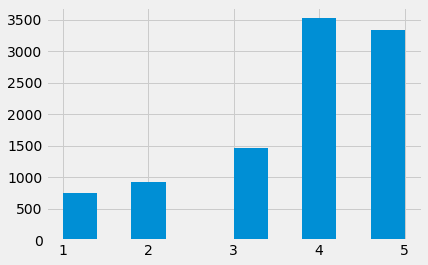

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.hist(data_df['stars'])

## Analysis
**There is a bias for higher ratings in this data set**

In [17]:
def good(x):
    if x > 3:
        return 1
    if x < 3:
        return 0

data_df['class']=data_df['stars'].apply(good)
data_df['length']=data_df['review_text'].apply(len)
summ=data_df.groupby(['stars']).mean()
summ

,cool,useful,funny,class,length
stars,,,,,
1,0.576769,1.604806,1.056075,0.0,826.515354
2,0.719525,1.563107,0.875944,0.0,842.256742
3,0.788501,1.306639,0.694730,NaN,758.498289
4,0.954623,1.395916,0.670448,1.0,712.923142
5,0.944261,1.381780,0.608631,1.0,624.999101


In [18]:
# Add stars to dataframe 
upload_class_df['class'] = data_df['stars'].apply(good)
upload_class_df.head()

,business_id,review_date,review_id,stars,review_text,review_type,user_id,cool,useful,funny,class
0,Lh9nz0KYyzE-YRbKuCYeUw,2010-01-16,-7yxrdY13ay15rGB7WibMA,5,I have been going to Arizona Auto Care since a...,review,ayKW9eWwGFcrtJaHcwZUCw,0,0,0,1.0
1,pa6K7DGByxBXxcVJ59nWMw,2011-01-25,-Be0UUGYuiDJVAM_YqeQuA,4,"Since Im big into breakfast foods, Im always o...",review,_4lqpCYCqOQzbB6xQGGhrQ,0,2,2,1.0
2,GIGI8bJfN6HyPzmEW-QqjA,2011-01-12,-nQHHXi-d_yuW301_Y0EZQ,2,"A pleasant place in Kierland Center, but has g...",review,4QORbyhfN01oKR_GgBstfQ,0,0,0,0.0
3,qiwajZigq_2twTmYofPmDQ,2010-01-24,2L30O7G8IQ6HILpR0t5RFA,5,"part of a social event, we only had app's here...",review,ST8Yzlk2MqKlcaLqL2djBg,0,0,0,1.0
4,9yKzy9PApeiPPOUJEtnvkg,2011-01-02,4x5yLG7_yGLuN-w6fV0eBw,4,I love every place on South Mountain. I've bee...,review,Vk-hJ1i5ZagPM87Kv9FOnA,0,1,0,1.0


In [20]:
upload_class_df = upload_class_df.filter(items=['review_id', 'class'])
spark_class_df = spark.createDataFrame(upload_class_df)
spark_class_df.show(4)

+--------------------+-----+
|           review_id|class|
+--------------------+-----+
|-7yxrdY13ay15rGB7...|  1.0|
|-Be0UUGYuiDJVAM_Y...|  1.0|
|-nQHHXi-d_yuW301_...|  0.0|
|2L30O7G8IQ6HILpR0...|  1.0|
+--------------------+-----+
only showing top 4 rows



In [24]:
# Write DataFrame to review_class table in Google Cloud
spark_class_df.write.jdbc(url=jdbc_url, table='review_class', mode=mode, properties=config)

In [27]:
data_df.head()

,review_text,class
0,I have been going to Arizona Auto Care since a...,1.0
1,"Since Im big into breakfast foods, Im always o...",1.0
2,"A pleasant place in Kierland Center, but has g...",0.0
3,"part of a social event, we only had app's here...",1.0
4,I love every place on South Mountain. I've bee...,1.0


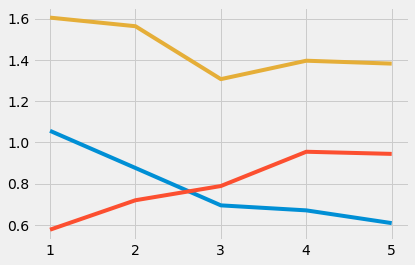

In [19]:
plt.plot(summ[['funny','cool','useful']])

## Analysis
**'Cool' evaluations are the only of the 3 that have a positive correlation with star ratings**

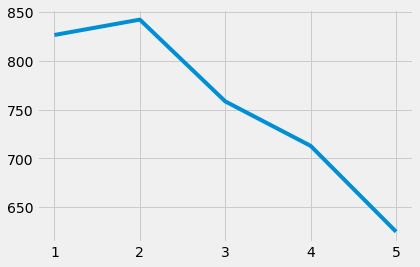

In [20]:
plt.plot(summ[['length']])

## Analysis
**The longer reviews tend to be lower ratings.**

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1676.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6863.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

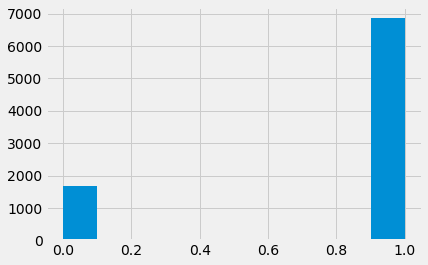

In [21]:
plt.hist(data_df['class'])

## Analysis
**Reaffirming the weighting bias in the data**

In [22]:
data_df=data_df.drop(['business_id','review_date','review_id','stars','review_type','user_id','cool','useful','funny','length'],axis=1)
data_df=data_df.dropna()

In [23]:
df = spark.createDataFrame(data_df)
df.show()

+--------------------+-----+
|         review_text|class|
+--------------------+-----+
|I have been going...|  1.0|
|Since Im big into...|  1.0|
|A pleasant place ...|  0.0|
|part of a social ...|  1.0|
|I love every plac...|  1.0|
|A great value for...|  1.0|
|I would never hav...|  1.0|
|The new Harkins C...|  1.0|
|This is one of my...|  1.0|
|OK, I went based ...|  1.0|
|I highly reccomen...|  1.0|
|I was severely mi...|  0.0|
|Where else can yo...|  1.0|
|My friend who I w...|  1.0|
|This place came r...|  0.0|
|Awesome food and ...|  1.0|
|Although the boba...|  1.0|
|It does not get m...|  1.0|
|May I add "family...|  1.0|
|Fantastic.  Absol...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [24]:
# Import functions
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer

In [ ]:
# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="token_text", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

In [ ]:
# Create and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [ ]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data_df)
cleaned = cleaner.transform(data_df)

In [ ]:
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3], 21)

In [ ]:
from pyspark.ml.classification import NaiveBayes
# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [ ]:
# Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(predictor.transform(testing))
print("Accuracy of model at predicting reviews was: %f" % acc)

Accuracy of model at predicting reviews was: 0.815244
